In [7]:
import typing 
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import matplotlib.animation as animation
from IPython.display import Image

sns.set_theme()

## Beta: distribution of probabilities

In [8]:
def plot_beta(
    alpha: float,
    beta: float,
    size: int = 1000,
    ax=None,
    bins: typing.Union[int, np.ndarray, str] = None,
):
    """Plot beta distribution"""
    r = st.beta.rvs(alpha, beta, size=size)
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 4))
    ax.hist(r, density=True, histtype="stepfilled", alpha=0.7, bins=bins)
    ax.set_xlabel("Conversion rate $\lambda$")
    ax.set_title("Beta(a = {:.2f}, b = {:.2f})".format(alpha, beta))
    return ax

<AxesSubplot:title={'center':'Beta(a = 8.00, b = 2.00)'}, xlabel='Conversion rate $\\lambda$'>

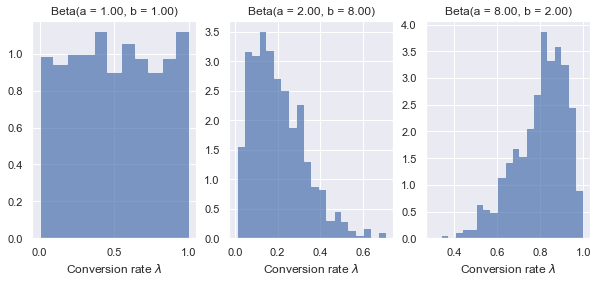

In [9]:
_, axes = plt.subplots(1, 3, figsize=(10, 4))
plot_beta(alpha=1, beta=1, ax=axes[0], bins="auto")
plot_beta(2, 8, ax=axes[1], bins="auto")
plot_beta(8, 2, ax=axes[2], bins="auto")

## Posterior distribution of conversion rate

After observing $n$ visitors and $c$ converted, the posterior distribution of conversion rate is given by:

$$P(\lambda | n, c) = Beta(x; a + c, b + (n - c))$$

A simulation to demonstrate this.

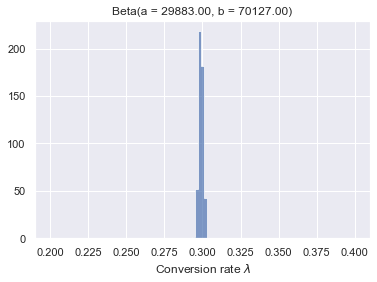

In [10]:
# global setup
global_a, global_b = 0, 0
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim((0, 1))
posterior_sim_output = "posterior_sim.gif"


def beta_posterior_simulation(i: int, lamb: float, a: int, b: int, N: int):
    """Simulate the updating process of posterior distribution

    :param i: number of func calls
    :type i: int
    :param lamb: conversion rate
    :type lamb: float
    :param a: prior belief on the number of successes
    :type a: int
    :param b: prior belief on the number of failures
    :type b: int
    :param N: number of samples
    :type N: int
    :return: plotting axis
    :rtype: Axis 
    """
    assert 0 <= lamb <= 1
    global global_a, global_b

    if i == 0:
        # initialize global_a, global_b
        global_a, global_b = a, b

    for _ in range(N):
        if np.random.rand() < lamb:
            # success
            global_a += 1
        else:
            # not success
            global_b += 1

    ax.clear()
    plot_beta(
        alpha=global_a,
        beta=global_b,
        ax=ax,
        bins=np.linspace(lamb-0.1, lamb+0.1, 100),
    )
    return ax


# actual conversion rate
lamb = 0.3
# prior Beta distribution
initial_a = 8
initial_b = 2
# run simulation over 100 * 1000 trials
ani = animation.FuncAnimation(
    fig,
    beta_posterior_simulation,
    repeat=True,
    frames=100,
    fargs=(lamb, initial_a, initial_b, 1000),
)
writer = animation.PillowWriter(fps=5, metadata=dict(artist="Me"), bitrate=1800)
ani.save(posterior_sim_output, writer=writer)

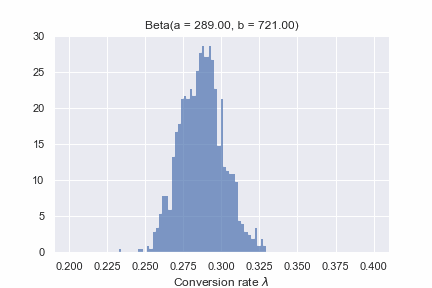

In [11]:
Image(open(posterior_sim_output,'rb').read())

## Join posterior distribution of conversion rates

At this point, we can compute the posterior of A and B separately.

Their joint poster distribution is defined as:

$$P(\lambda_A, \lambda_B) = P_A(\lambda_A) P_B(\lambda_B)$$

In [25]:
def beta_posterior_fn(a: float, b: float, n: int, c: int):
    """Return posterior distribution"""
    return st.beta(a + c, b + n - c)

def mc_joint_beta_posterior_AB(A_params: tuple, B_params: tuple, N: int = 100) -> np.ndarray:
    """Compute joint posterior distribution of A and B

    :param A_params: tuple (a, b, n, c) of A
    :type A_params: tuple
    :param B_params: tuple (a, b, n, c) of B
    :type B_params: tuple
    :param N: number of steps, defaults to 100
    :type N: int 
    :return: joint posterior distribution in 2D matrix
    :rtype: np.ndarray 
    """
    joint_posterior = np.zeros(shape=(N, N))
    f_A = beta_posterior_fn(*A_params)
    f_B = beta_posterior_fn(*B_params)
    
    for i,lamb_A in enumerate(np.linspace(0, 1, N)):
            joint_posterior[i, :] = f_A.pdf(lamb_A) * f_B.pdf(np.linspace(0, 1, N))
            
    return joint_posterior

In [26]:
A_params = (1, 1, 50, 2) # CR = 4%
B_params = (1, 1, 50, 4) # CR = 8%
joint_posterior_AB = mc_joint_beta_posterior_AB(A_params, B_params, N=100)

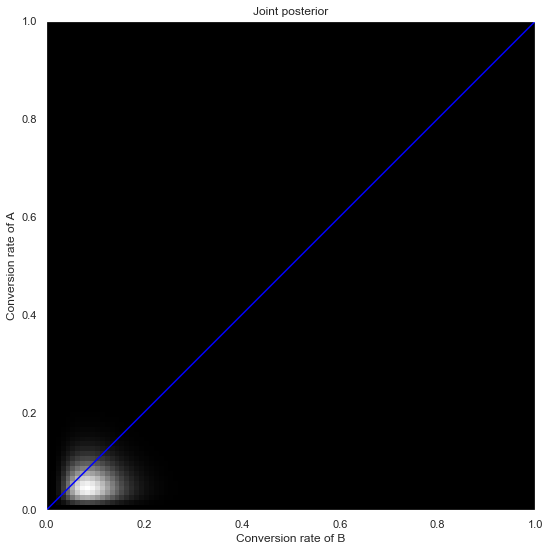

In [27]:
plt.figure(figsize=(9, 9))
plt.imshow(joint_posterior_AB/joint_posterior_AB.sum(), 
           cmap='gray', 
           extent=[0, 1, 0, 1], 
           origin="lower")
plt.plot([0, 1], [0, 1], color="blue")
plt.ylabel("Conversion rate of A")
plt.xlabel("Conversion rate of B")
plt.title("Joint posterior")
plt.grid(None)

## Chance of winning

Probability that $\lambda_B > \lambda_A$ = probability that we make mistake by choosing A.

$$E[I](A) = \int_{0}^{1} \int_{\lambda_A}^{1} P(\lambda_A, \lambda_B) d \lambda_B d \lambda_A$$

Similarly, probability that $\lambda_A > \lambda_B$ = probability that we make mistake by choosing B.

$$E[I](B) = \int_{0}^{1} \int_{0}^{\lambda_A} P(\lambda_A, \lambda_B) d \lambda_B d \lambda_A$$

This definition is intuitively the obvious choice to determine whether it is worthwhile to continue the test.

Compute chance of winning using Monte Carlo estimator.

$$F = \int_{a}^{b}f(x)dx$$

$$\langle F^N \rangle = (b-a)\frac{1}{N}\sum_{i=0}^{N-1}f(X_i)$$

In [39]:
def chance_of_winning(A_params: tuple, B_params: tuple, N: int =1_000_000) -> tuple:
    """Compute chances of winning

    :param A_params: tuple (a, b, n, c) of A
    :type A_params: tuple
    :param B_params: tuple (a, b, n, c) of B
    :type B_params: tuple
    :param N: number of steps, defaults to 1_000_000
    :type N: int 
    :return: probability of A as the winner, B as the winner
    :rtype: tuple
    """
    f_A = beta_posterior_fn(*A_params)
    f_B = beta_posterior_fn(*B_params)
    
    spaces = np.linspace(0, 1, N)
    p_win_A, p_win_B = 0, 0
    pdf_B = f_B.pdf(spaces)
    
    for i, lamb_A in enumerate(spaces):
        lt_mask = spaces < lamb_A
        gt_mask = spaces >= lamb_A
        p_win_B += np.array([ f_A.pdf(lamb_A) * pdf_B * gt_mask ]).sum() * (1 - lamb_A) / (N - i)
        p_win_A += np.array([ f_A.pdf(lamb_A) * pdf_B * lt_mask ]).sum() * lamb_A  / (i + 1e-12)

    return p_win_A / N, p_win_B / N

In [40]:
A_params = (1, 1, 50, 11) # CR = 0%
B_params = (1, 1, 50, 10) # CR = 1%

p_win_A, p_win_B = chance_of_winning(A_params, B_params, N=10_000)
print(f'Probability of A as winner = {p_win_A*100:.1f}%')
print(f'Probability of B as winner = {p_win_B*100:.1f}%')

Probability of A as winner = 59.5%
Probability of B as winner = 40.5%


A more "engineering way" to compute probability of winning using Monte Carlo sampling ([Reference](https://github.com/Arngren/bayesian-ab-test/blob/main/bayesian_ab_testing.ipynb)).

In [41]:
n_samples = 1_000_000

samples_a = beta_posterior_fn(*A_params).rvs(size=n_samples)
samples_b = beta_posterior_fn(*B_params).rvs(size=n_samples)

ratio = samples_b / samples_a
hist, bins = np.histogram(ratio, bins=1000)
id1, id2 = bins<=1.0, bins>1.0

p_ratio_A = np.sum(hist[id1[:-1]]) / n_samples
p_ratio_B = np.sum(hist[id2[:-1]]) / n_samples

print(f'Probability of A as winner = {p_ratio_A*100:.1f}%')
print(f'Probability of B as winner = {p_ratio_B*100:.1f}%')

Probability of A as winner = 59.9%
Probability of B as winner = 40.1%


## Loss

**Loss**: the amount of uplift that one can expect to be lost by chosing the given variant.

$$L(\lambda_A, \lambda_B, A) = \max(\lambda_B - \lambda_A, 0)$$

$$L(\lambda_A, \lambda_B, B) = \max(\lambda_A - \lambda_B, 0)$$

In [43]:
def loss(lamb_A: tuple, lamb_B: tuple, var: str) -> typing.Union[float, np.ndarray]:
    """Compute the loss of choosing a given variant

    :param lamb_A: tuple (a, b, n, c) of A
    :type lamb_A: tuple
    :param lamb_B: tuple (a, b, n, c) of A
    :type lamb_B: tuple
    :param var: variant, "A" or "B"
    :type var: str
    :raises ValueError: raise exception for unsupported variant
    :return: loss value
    :rtype: typing.Uninon[float, np.ndarray] 
    """
    if var=="A":
        return np.clip(lamb_B - lamb_A, a_min=0.0, a_max=None)
    if var=="B":
        return np.clip(lamb_A - lamb_B, a_min=0.0, a_max=None)
    
    raise ValueError(f"{var} is not supported")

**Expected loss**

$$E[L](?) = \int_0^1 \int_0^1 L(\lambda_A, \lambda_B, ?)P(\lambda_A, \lambda_B) d\lambda_B d\lambda_A$$

In [44]:
def expected_loss(A_params, B_params, N=100):
    f_A = beta_posterior_fn(*A_params)
    f_B = beta_posterior_fn(*B_params)
    
    loss_A, loss_B = 0, 0
    for _, lamb_A in enumerate(np.linspace(0, 1, N)):
        
        lamb_B_arr = np.linspace(0, 1, N)
        posterior_AB = f_A.pdf(lamb_A) * f_B.pdf(lamb_B_arr)
        
        loss_A += (posterior_AB * loss(lamb_A, lamb_B_arr, "A")).sum()
        loss_B += (posterior_AB * loss(lamb_A, lamb_B_arr, "B")).sum()

    return loss_A / (N*N), loss_B / (N*N) 

In [45]:
A_params = (1, 1, 1000, 110) # CR = 11%
B_params = (1, 1, 1000, 150) # CR = 15%

loss_A, loss_B = expected_loss(A_params, B_params, N=1000)

print(f"Expected loss by choosing A: {loss_A:.6f}")
print(f"Expected loss by choosing B: {loss_B:.6f}")

Expected loss by choosing A: 0.039859
Expected loss by choosing B: 0.000018


## Running an A/B test

Suppose we are testing two button colors, and we are interested in measuring lift of 10ppt. Conversely, if the lift we get from this test changes negatively by 0.2ppt or less, this change is so small that we don’t care. In that case, we can choose $\epsilon$ = 0.002.

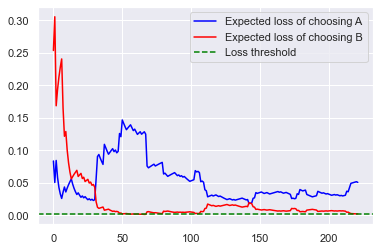

In [58]:
AB_sim_output = "AB_sim.gif"
fig, ax = plt.subplots(figsize=(6, 4))

# actual conversion rates
lamb_A, lamb_B, eps = 0.05, 0.15, 0.002
n_A, c_A, n_B, c_B = 0, 0, 0, 0
loss_A, loss_B = [], []
it = 0


def plot_loss(loss_A: list, loss_B, eps, ax):
    ax.clear()
    ax.plot(loss_A, label="Expected loss of choosing A", color="blue")
    ax.plot(loss_B, label="Expected loss of choosing B", color="red")
    ax.axhline(y=eps, color="green", linestyle="dashed", label="Loss threshold")
    ax.legend()
    return ax


def A_B_simulation(
    i: int, lamb_A: float, lamb_B: float, eps: float, max_iters: int = int(1e5)
):
    """Simulate AB experimentation

    :param i: number of func calls
    :type i: int
    :param lamb_A: underlying conversion rate of A
    :type lamb_A: float
    :param lamb_B: underlying conversion rate of B
    :type lamb_B: float
    :param eps: error threshold used to stop experiment
    :type eps: float
    :param max_iters: maximum of iterations for one function call, defaults to int(1e5)
    :type max_iters: int 
    :return: plotting axis
    :rtype: Axis
    """
    global n_A, c_A, n_B, c_B, it, loss_B, loss_A

    A_conv_fn = st.bernoulli(lamb_A)
    B_conv_fn = st.bernoulli(lamb_B)
    while it < max_iters:
        if np.random.rand() < 0.5:
            n_A += 1
            c_A += A_conv_fn.rvs(size=1)
        else:
            n_B += 1
            c_B += B_conv_fn.rvs(size=1)

        losses = expected_loss([1, 1, n_A, c_A], [1, 1, n_B, c_B], N=100)

        loss_A.append(losses[0])
        loss_B.append(losses[1])

        if losses[0] < eps or losses[1] < eps:
            return  # plot_loss(loss_A, loss_B, eps, ax=ax)

        if (it + 1) % 10 == 0:
            return plot_loss(loss_A, loss_B, eps, ax=ax)

        it += 1


# run simulation over 1e6 trials
ani = animation.FuncAnimation(
    fig,
    A_B_simulation,
    repeat=True,
    frames=500,
    fargs=(lamb_A, lamb_B, eps),
)
writer = animation.PillowWriter(fps=5, metadata=dict(artist="Me"), bitrate=1800)
ani.save(AB_sim_output, writer=writer)

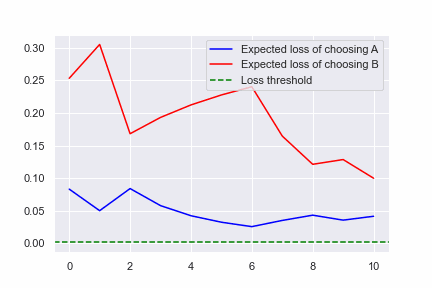

In [59]:
Image(open(AB_sim_output,'rb').read())